In [1]:
import numpy as np

import matplotlib.pyplot as plt

#### 1.1 Init parameters


In [3]:
m = 1
n = 3
Tf = 100 
Delta_T = 0.0001

TimeSpan = np.arange(0, Tf, Delta_T)
nt = TimeSpan.shape[0] # mt do not use in python 

u = np.zeros((nt,m))
x = np.zeros((nt,n))

#print('TimeSpan:\n',TimeSpan[:5], '\nnt:\n', nt, '\nu:\n', u,'\nx:\n', x)

#### 1.2 Init variables x and u


In [4]:
for j in range(n):
    x[0][j] = 2*(j+1)

A_s = 0.001 * np.diag([-5,-7,-6])
B = np.array([0, 0, 1])#.reshape(-3, 1)

for i in range(nt-1):
    u[i] = 500 * np.sin(0.00004*i) * np.cos(0.000009*i+1.15)

    x[i+1][:] = x[i][:] + Delta_T * ( np.matmul(A_s, x[i][:]) + B * u[i] + np.random.random_sample(3) * np.array([70, 80, 90]) )

In [5]:
np.mean(x)
# matlab: mean(x, 'all') -> 1.7964e+03

1796.4060090916278

In [6]:
x1 = x[:,0]
x2 = x[:,1]
x3 = x[:,2]

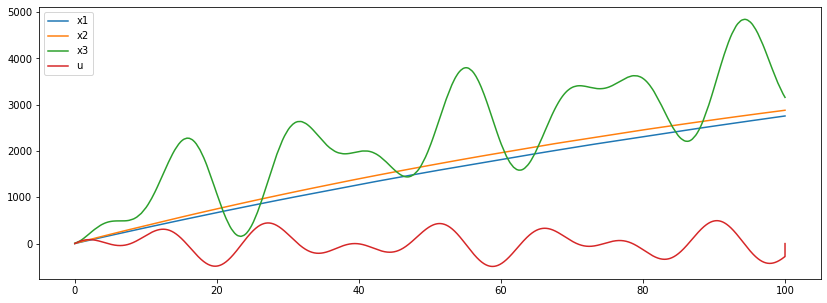

In [7]:
plt.figure(figsize=(14,5)) 

plt.plot(TimeSpan, x1, label='x1')
plt.plot(TimeSpan, x2, label='x2')
plt.plot(TimeSpan, x3, label='x3')
plt.plot(TimeSpan, u, label='u')

plt.legend()

#### 2.2 Define learning law


In [9]:
def ll_e(x, nt):

    A = 20 * np.diag([-2, -2, -2])
    P = 1575.9 * np.diag([60, 40, 40])

    n1 = 4
    n2 = 5

    xe = 9 * np.ones((nt,n))

    W1 = 20 * np.ones((n,n1))
    W2 = 20 * np.ones((n,n2))

    W1_S = np.ones((nt,n,n1))
    W2_S = np.ones((nt,n,n2))

    W1_S[0] = W1
    W2_S[0] = W2

    sigma1 = np.zeros((nt,1,n1))
    sigma2 = np.zeros((nt,m,n2))

    K1 = 0.1 * np.diag([20, 10, 20])
    K2 = 0.1 * np.diag([20, 10, 20])

    C = 0.1 * np.array([1, 1, 1]).reshape(-3,1)

    for i in range(nt-1):

        # Sigma 1
        for j in range(n1):
            sigma1[0][0][j] = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.3)
        
        # Sigma 2
        for j in range(n2):
            for k in range(m):
                sigma2[k][0][j] = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.2)

        #print(sigma1[0])
        #print(sigma2[0])

        Delta = xe - x 

        xe[i+1] = xe[i] + Delta_T * (np.matmul(A, xe[i]) + np.matmul(W1, sigma1[0][0]) + np.matmul(W2, sigma2[i][0]) * u[i+1])

        W1 = W1 - Delta_T * (np.matmul( np.matmul(K1,P), Delta[i] ).reshape(-3,1) * sigma1[0][0])
        W2 = W2 - Delta_T * (np.matmul( np.matmul(K2,P), Delta[i] ).reshape(-3,1) * u[i+1] * sigma2[i][0])

        # ?? How use for t > TimeSpan ?? 
        W1_S[i+1] = W1
        W2_S[i+1] = W2

    return xe 

In [10]:
def ll_rk(x, nt):
    A = 20 * np.diag([-2, -2, -2])
    P = 1575.9 * np.diag([60, 40, 40])

    n1 = 4
    n2 = 5

    xe = 9 * np.ones((nt,n))

    W1 = 20 * np.ones((n,n1))
    W2 = 20 * np.ones((n,n2))

    W1_S = np.ones((nt,n,n1))
    W2_S = np.ones((nt,n,n2))

    W1_S[0] = W1
    W2_S[0] = W2

    sigma1 = np.zeros((nt,1,n1))
    sigma2 = np.zeros((nt,m,n2))

    K1 = 0.1 * np.diag([20, 10, 20])
    K2 = 0.1 * np.diag([20, 10, 20])

    C = 0.1 * np.array([1, 1, 1]).reshape(-3,1)

    k_1 = 0
    k_2 = 0
    k_3 = 0
    k_4 = 0

    for i in range(nt-1):

        # FOR k_1

        # Sigma 1
        for j in range(n1):
            sigma1[0][0][j] = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.3)
        
        # Sigma 2
        for j in range(n2):
            for k in range(m):
                sigma2[k][0][j] = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.2)

        #print(sigma1[0])
        #print(sigma2[0])
        k_1 = np.matmul(A, xe[i]) + np.matmul(W1, sigma1[0][0]) + np.matmul(W2, sigma2[i][0]) * u[i+1]

        # FOR k_2
        
        # Sigma 1
        for j in range(n1):
            sigma1[0][0][j] = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul( (x[i] + 0.5*Delta_T*k_1), C)) - 0.3) )
         
        # Sigma 2
        for j in range(n2):
            for k in range(m):
                sigma2[k][0][j] = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul( (x[i] + 0.5*Delta_T*k_1), C))) - 0.2)

        k_2 =  np.matmul(A, (x[i] + 0.5*Delta_T*k_1) ) + np.matmul(W1, sigma1[0][0]) + np.matmul(W2, sigma2[i][0]) * u[i+1]

        # FOR k_3
        
        # Sigma 1
        for j in range(n1):
            sigma1[0][0][j] = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul( (x[i] + 0.5*Delta_T*k_2), C)) - 0.3) )
         
        # Sigma 2
        for j in range(n2):
            for k in range(m):
                sigma2[k][0][j] = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul( (x[i] + 0.5*Delta_T*k_2), C))) - 0.2)

        k_3 =  np.matmul(A, (x[i] + 0.5*Delta_T*k_2) ) + np.matmul(W1, sigma1[0][0]) + np.matmul(W2, sigma2[i][0]) * u[i+1]

        # FOR k_4
        
        # Sigma 1
        for j in range(n1):
            sigma1[0][0][j] = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul( (x[i] + Delta_T*k_3), C)) - 0.3) )
         
        # Sigma 2
        for j in range(n2):
            for k in range(m):
                sigma2[k][0][j] = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul( (x[i] + Delta_T*k_3), C))) - 0.2)

        k_4 =  np.matmul(A, (x[i] + Delta_T*k_3) ) + np.matmul(W1, sigma1[0][0]) + np.matmul(W2, sigma2[i][0]) * u[i+1]

        #print(k_1)
        #print(k_2)
        #print(k_3)
        #print(k_4)

        xe[i+1] = xe[i] + Delta_T * ( k_1 + 2*k_2 + 2*k_3 + k_4  ) / 6.

        Delta = xe - x 

        W1 = W1 - Delta_T * 0.01 * (np.matmul( np.matmul(K1,P), Delta[i] ).reshape(-3,1) * sigma1[0][0])
        W2 = W2 - Delta_T * 0.01 * (np.matmul( np.matmul(K2,P), Delta[i] ).reshape(-3,1) * u[i+1] * sigma2[i][0])

        # ?? How use for t > TimeSpan ?? 
        W1_S[i+1] = W1
        W2_S[i+1] = W2

    return xe

#### 2.3 Plot results


In [11]:
test_xe = np.load('xe_data.npy')
test_xrk = np.load('xrk_data.npy')

In [12]:
xe1 = test_xe[:,0]
xe2 = test_xe[:,1]
xe3 = test_xe[:,2]

xrk1 = test_xrk[:,0]
xrk2 = test_xrk[:,1]
xrk3 = test_xrk[:,2]

In [17]:
def plot(TimeSpan, x, xe, xrk, k = 1000):
    plt.figure(figsize=(14,5)) 

    plt.plot(TimeSpan[:k], x[:k], label='x')
    plt.plot(TimeSpan[:k], xe[:k], label='xe')
    plt.plot(TimeSpan[:k], xrk[:k], label='xrk')

    plt.legend()

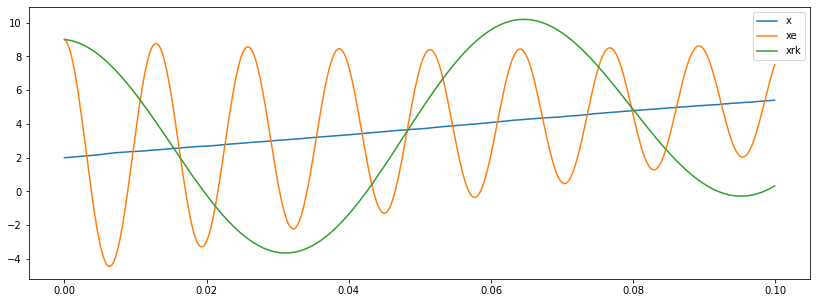

In [18]:
plot(TimeSpan, x1, xe1, xrk1, k = 1000)

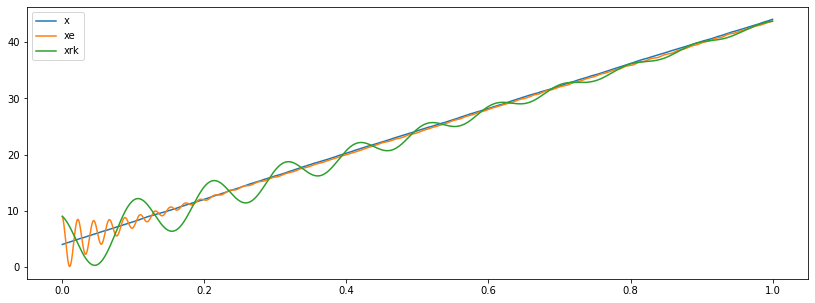

In [23]:
plot(TimeSpan, x2, xe2, xrk2, k = 10000)

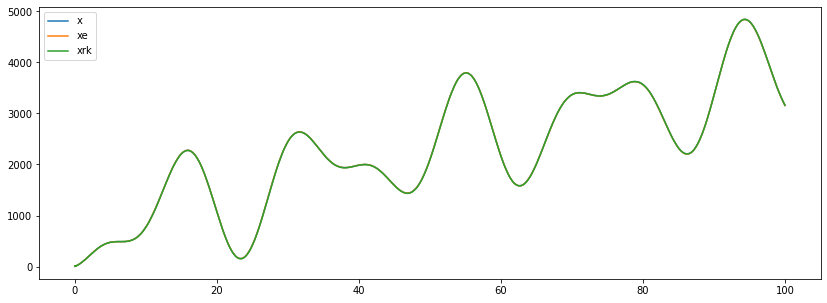

In [21]:
plot(TimeSpan, x3, xe3, xrk3, k = nt)

In [28]:
np.linalg.norm(test_xe - test_xrk)

2875.7807842335737